In [1]:
# 设置绘图
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
#设置字体为SimHei显示中文
plt.rcParams['font.sans-serif'] = 'SimHei'
#设置正常显示字符
plt.rcParams['axes.unicode_minus'] = False

import pandas as pd
import numpy as np
import xgboost
import math

In [7]:
from keras.models import Sequential  # 采用贯序模型
from keras.layers import Input, Dense, Dropout, Activation,LSTM
from keras.models import Model
from keras.optimizers import SGD
import numpy as np

In [2]:
df=pd.read_excel('T_30min.xlsx',index_col=0)


# 使用百分比变化
df['r']=(df['close']/df['open']-1)
df['range']=(df['high']/df['low']-1)
dataset=df[['r','range','volume']]
dataset

,r,range,volume
2017-12-18 09:45:00,0.000914,0.001613,6729
2017-12-18 10:15:00,-0.000483,0.000753,3445
2017-12-18 10:45:00,-0.000806,0.001076,2849
2017-12-18 11:15:00,0.000377,0.000646,1295
2017-12-18 13:15:00,0.000000,0.000376,1269
...,...,...,...
2020-12-17 13:30:00,0.000206,0.000617,4083
2020-12-17 14:00:00,0.000000,0.000360,3955
2020-12-17 14:30:00,-0.000360,0.000669,4976
2020-12-17 15:00:00,-0.000154,0.000411,3783


In [8]:
def create_dataset_softmax(dataset:np.ndarray, look_back:int):  # 后一个数据和前look_back个数据有关系
    assert not (isinstance(dataset,np.ndarray) and isinstance(dataset,pd.core.frame.DataFrame)) ,'输入数据格式不符合要求，使用pandas或numpy'
    dataset=np.array(dataset)

    dataX, dataY = [],[]
    rr=[]
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back)]
        dataX.append(a)  # .apeend方法追加元素
        rr.append(dataset[:,0][i + look_back])
        if dataset[:,0][i + look_back]>0:
            dataY.append([1,0]) #【1,0】表示涨了
        else:
            dataY.append([0,1])
        
    rr=np.array(rr)   
    rr=np.reshape(rr,(rr.shape[0],-1))
    # dataY.append(dataset[:,0][i + look_back]) #此处Y要第一列（收益率） 
        
    dataX,dataY=np.array(dataX),np.array(dataY)
    
    dataX,dataY=np.reshape(dataX,(dataX.shape[0],-1)),np.reshape(dataY,(dataY.shape[0],-1))# 转变为二维数据
    
    # 进行归一化
    from sklearn.preprocessing import MinMaxScaler
    
    scalerX = MinMaxScaler(feature_range=(0, 1))  # 归一化0-1
    scalerX.fit(dataX)
    dataX=scalerX.transform(dataX)

    scalerY = MinMaxScaler(feature_range=(0, 1))  # 归一化0-1
    scalerY.fit(dataY)
    dataY=scalerY.transform(dataY)
    
    return np.array(dataX), np.array(dataY),scalerX,scalerY ,rr # 生成输入数据和输出数据


look_back = 20

totX, totY, scalerX, scalerY,rr = create_dataset_softmax(np.array(dataset), look_back)  # 训练输入输出



In [9]:
def split_dataset(dataset):
    dataset=np.array(dataset)
    train_size = int(len(dataset) * 0.67)  # %67的训练集，剩下测试集
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]  # 训练集和测试集    
    return train,test

trainX,testX=split_dataset(totX)
trainY,testY=split_dataset(totY)
trainR,testR=split_dataset(rr)
print(trainX.shape)

(4387, 60)


In [10]:
tBatchSize = 128
'''第一步：选择模型'''
model = Sequential()  # 采用贯序模型

'''第二步：构建网络层'''
'''构建网络只是构建了一个网络结构，并定义网络的参数，此时还没有输入的数据集'''
# 构建的第一个层作为输入层
# Dense 这是第一个隐藏层，并附带定义了输入层，该隐含层有500个神经元。输入则是 784个节点
model.add(Dense(50, input_shape=(60,)))  # 输入层，28*28=784 输入层将二维矩阵换成了一维向量输入
model.add(Activation('relu'))  # 激活函数是tanh 为双曲正切  tanh(x) = sinh(x)/cosh(x) = (e^x - e^(-x))/(e^x + e^(-x))
model.add(Dropout(0.5))  # 采用50%的dropout  随机取一半进行训练

# 构建的第2个层作为隐藏层2， （如果加上输入层，实际上是第三层）
model.add(Dense(50))  # 隐藏层节点500个
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(50))  # 隐藏层3，节点500个
model.add(Activation('relu'))
# model.add(Dropout(0.5))

# 构建的第3个层作为输出层
model.add(Dense(2))  # 输出结果是10个类别，所以维度是10
# softmax介绍可以参考https://blog.csdn.net/haolexiao/article/details/72757796
model.add(Activation('softmax'))  # 最后一层用softmax作为激活函数

In [11]:
'''第三步：网络优化和编译'''
#   lr：大于0的浮点数，学习率
#   momentum：大于0的浮点数，动量参数
#   decay：大于0的浮点数，每次更新后的学习率衰减值
#   nesterov：布尔值，确定是否使用Nesterov动量
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)  # 优化函数，设定学习率（lr）等参数

# 只有通过了编译，model才真正的建立起来，这时候才能够被使用
model.compile(loss='categorical_crossentropy', optimizer=sgd)  # 使用交叉熵作为loss函数    # 去掉 class_mode 即可。可能是版本不同导致的？？？

In [12]:
model.fit(trainX, trainY, batch_size=tBatchSize, epochs=100, shuffle=True, verbose=1, validation_split=0.3)
print('模型训练完成')
# model.evaluate(testX, testY, batch_size=200, verbose=0)


Epoch 1/100
24/24 [==============================] - 0s 7ms/step - loss: 0.7049 - val_loss: 0.6943
Epoch 2/100
24/24 [==============================] - 0s 2ms/step - loss: 0.6983 - val_loss: 0.6944
Epoch 3/100
24/24 [==============================] - 0s 2ms/step - loss: 0.6939 - val_loss: 0.6942
Epoch 4/100
24/24 [==============================] - 0s 2ms/step - loss: 0.6961 - val_loss: 0.6942
Epoch 5/100
24/24 [==============================] - 0s 2ms/step - loss: 0.6991 - val_loss: 0.6935
Epoch 6/100
24/24 [==============================] - 0s 2ms/step - loss: 0.6925 - val_loss: 0.6931
Epoch 7/100
24/24 [==============================] - 0s 2ms/step - loss: 0.6944 - val_loss: 0.6937
Epoch 8/100
24/24 [==============================] - 0s 2ms/step - loss: 0.6945 - val_loss: 0.6932
Epoch 9/100
24/24 [==============================] - 0s 2ms/step - loss: 0.6939 - val_loss: 0.6938
Epoch 10/100
24/24 [==============================] - 0s 2ms/step - loss: 0.6939 - val_loss: 0.6934
Epoch 11/

In [ ]:
def result_plot_softmax(result):
    result_raw=scalerY.inverse_transform(result)
    testY_raw=scalerY.inverse_transform(testY)
    

    result_df=pd.DataFrame({'pred':result_raw[:,0]>result_raw[:,1]}) 
    result_df['real']=testR[:,0]

    result_df['buy']=(result_df['pred']==True) #只做多
    result_df['buy_and_sell']=result_df['pred'].apply(lambda x:1 if x>0 else -1 ) # 加做空

    result_df['real_return']=(1+result_df['real']).cumprod()
    result_df['stg_buy']=((result_df['real']*result_df['buy'])+1).cumprod()
    result_df['stg_buy_and_sell']=((result_df['real']*result_df['buy_and_sell'])+1).cumprod()
    return result_df


result= model.predict(testX, batch_size=tBatchSize, verbose=0)
result_df=result_plot_softmax(result)
result_df

In [ ]:
result_df[['real_return','stg_buy','stg_buy_and_sell']].plot()


,pred,real,buy,buy_and_sell,real_return,stg_buy,stg_buy_and_sell
0,True,0.000205,True,1,1.000205,1.000205,1.000205
1,True,0.000818,True,1,1.001023,1.001023,1.001023
2,True,0.000307,True,1,1.001329,1.001329,1.001329
3,True,-0.000153,True,1,1.001176,1.001176,1.001176
4,True,0.000460,True,1,1.001636,1.001636,1.001636
...,...,...,...,...,...,...,...
2156,True,-0.000257,True,1,1.001456,0.978965,0.956803
2157,True,0.000206,True,1,1.001662,0.979166,0.957000
2158,True,0.000000,True,1,1.001662,0.979166,0.957000
2159,True,-0.000360,True,1,1.001302,0.978814,0.956655


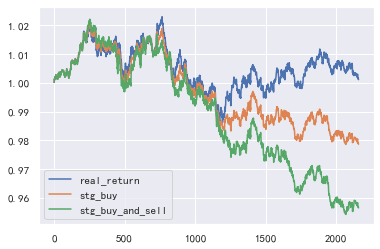

In [14]:
result_df[['real_return','stg_buy','stg_buy_and_sell']].plot()
